In [1]:
# Imports
from pathlib import Path

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, roc_auc_score, classification_report, confusion_matrix

import shap  # Evaluation için SHAP

sns.set_theme(style="whitegrid")
shap.__version__


'0.50.0'

In [2]:
# Load dataset
data_path = Path("../../data/raw/online_shoppers_intention.csv")
df = pd.read_csv(data_path)

df["Revenue"] = df["Revenue"].astype(int)
y = df["Revenue"]
X = df.drop(columns=["Revenue"])

# Feature engineering (03'te yaptığımızın aynısı)
X_fe = X.copy()

X_fe["Total_Duration"] = (
    X_fe["Administrative_Duration"]
    + X_fe["Informational_Duration"]
    + X_fe["ProductRelated_Duration"]
)

X_fe["PageValue_per_Product"] = X_fe["PageValues"] / (X_fe["ProductRelated"] + 1e-3)

high_season_months = ["Nov", "Dec", "Mar", "May"]
X_fe["Is_HighSeason"] = X_fe["Month"].isin(high_season_months).astype(int)

X_fe["Is_ReturningVisitor"] = (X_fe["VisitorType"] == "Returning_Visitor").astype(int)

print("Before FE:", X.shape, "After FE:", X_fe.shape)
X_fe.head()


Before FE: (12330, 17) After FE: (12330, 21)


,Administrative,Administrative_Duration,Informational,Informational_Duration,ProductRelated,ProductRelated_Duration,BounceRates,ExitRates,PageValues,SpecialDay,...,OperatingSystems,Browser,Region,TrafficType,VisitorType,Weekend,Total_Duration,PageValue_per_Product,Is_HighSeason,Is_ReturningVisitor
0,0,0.0,0,0.0,1,0.000000,0.20,0.20,0.0,0.0,...,1,1,1,1,Returning_Visitor,False,0.000000,0.0,0,1
1,0,0.0,0,0.0,2,64.000000,0.00,0.10,0.0,0.0,...,2,2,1,2,Returning_Visitor,False,64.000000,0.0,0,1
2,0,0.0,0,0.0,1,0.000000,0.20,0.20,0.0,0.0,...,4,1,9,3,Returning_Visitor,False,0.000000,0.0,0,1
3,0,0.0,0,0.0,2,2.666667,0.05,0.14,0.0,0.0,...,3,2,2,4,Returning_Visitor,False,2.666667,0.0,0,1
4,0,0.0,0,0.0,10,627.500000,0.02,0.05,0.0,0.0,...,3,3,1,4,Returning_Visitor,True,627.500000,0.0,0,1


In [3]:
# Train / test split
X_train, X_test, y_train, y_test = train_test_split(
    X_fe, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

# Numeric / categorical kolonlar
numeric_features_fe = X_fe.select_dtypes(include=["int64", "float64"]).columns.tolist()
categorical_features_fe = X_fe.select_dtypes(include=["object", "bool"]).columns.tolist()

print("Numeric (FE):", numeric_features_fe)
print("Categorical (FE):", categorical_features_fe)

# Preprocessing
numeric_transformer = Pipeline(steps=[
    ("scaler", StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ("onehot", OneHotEncoder(handle_unknown="ignore"))
])

preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_features_fe),
        ("cat", categorical_transformer, categorical_features_fe),
    ]
)


Numeric (FE): ['Administrative', 'Administrative_Duration', 'Informational', 'Informational_Duration', 'ProductRelated', 'ProductRelated_Duration', 'BounceRates', 'ExitRates', 'PageValues', 'SpecialDay', 'OperatingSystems', 'Browser', 'Region', 'TrafficType', 'Total_Duration', 'PageValue_per_Product', 'Is_HighSeason', 'Is_ReturningVisitor']
Categorical (FE): ['Month', 'VisitorType', 'Weekend']


In [4]:
# Optimized RandomForest pipeline (best params from 03_Model_Optimization)

rf_best = Pipeline(
    steps=[
        ("preprocess", preprocessor),
        ("clf", RandomForestClassifier(
            n_estimators=150,
            min_samples_split=5,
            min_samples_leaf=8,
            max_features="sqrt",
            max_depth=None,
            class_weight="balanced",
            random_state=42,
        ))
    ]
)

rf_best.fit(X_train, y_train)

y_pred = rf_best.predict(X_test)
y_proba = rf_best.predict_proba(X_test)[:, 1]

acc = accuracy_score(y_test, y_pred)
auc = roc_auc_score(y_test, y_proba)

print(f"Optimized RF - Test Accuracy: {acc:.4f}")
print(f"Optimized RF - Test ROC-AUC: {auc:.4f}")
print("\nClassification report:\n", classification_report(y_test, y_pred))


Optimized RF - Test Accuracy: 0.8751
Optimized RF - Test ROC-AUC: 0.9288

Classification report:
               precision    recall  f1-score   support

           0       0.96      0.89      0.92      2084
           1       0.57      0.77      0.66       382

    accuracy                           0.88      2466
   macro avg       0.76      0.83      0.79      2466
weighted avg       0.90      0.88      0.88      2466



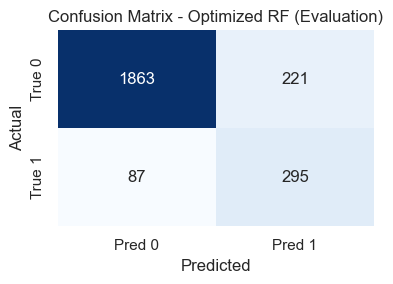

In [5]:
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(4,3))
sns.heatmap(
    cm,
    annot=True,
    fmt="d",
    cmap="Blues",
    cbar=False,
    xticklabels=["Pred 0", "Pred 1"],
    yticklabels=["True 0", "True 1"]
)
plt.title("Confusion Matrix - Optimized RF (Evaluation)")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.tight_layout()
plt.show()


In [6]:
# Feature importance

# 1) Preprocess edilmiş feature isimlerini al
feature_names = rf_best.named_steps["preprocess"].get_feature_names_out()

# 2) RF içindeki önemler
clf = rf_best.named_steps["clf"]
importances = clf.feature_importances_

fi_df = pd.DataFrame({
    "feature": feature_names,
    "importance": importances
}).sort_values("importance", ascending=False)

fi_df.head(20)


,feature,importance
8,num__PageValues,0.288135
15,num__PageValue_per_Product,0.272698
7,num__ExitRates,0.067668
14,num__Total_Duration,0.048451
5,num__ProductRelated_Duration,0.048094
4,num__ProductRelated,0.044343
6,num__BounceRates,0.035487
25,cat__Month_Nov,0.033367
1,num__Administrative_Duration,0.030309
0,num__Administrative,0.022288


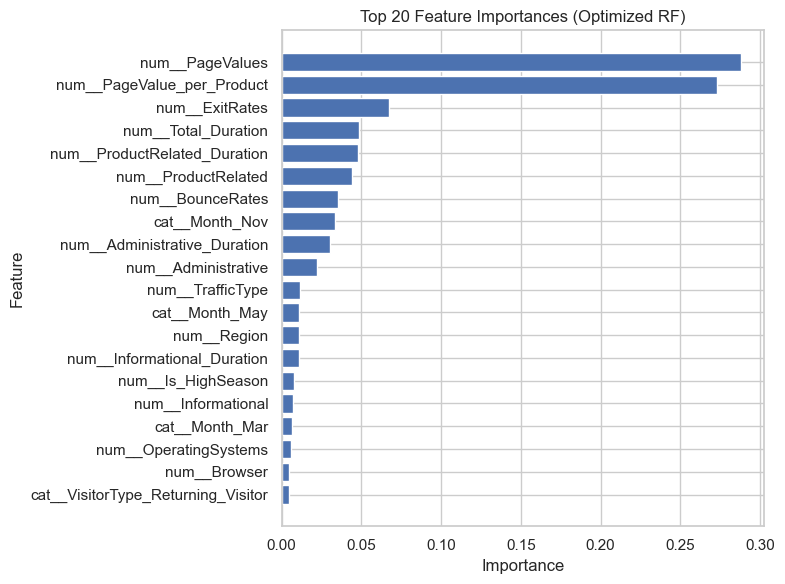

In [7]:
top_n = 20
fi_top = fi_df.head(top_n).sort_values("importance", ascending=True)

plt.figure(figsize=(8, 6))
plt.barh(fi_top["feature"], fi_top["importance"])
plt.title(f"Top {top_n} Feature Importances (Optimized RF)")
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()


In [8]:
# SHAP için: eğitim setinden örnek bir alt küme alalım
X_sample = X_train.sample(n=1000, random_state=42)

# Preprocess et
X_sample_enc = rf_best.named_steps["preprocess"].transform(X_sample)

# Eğer sparse ise dense'e çevir (SHAP rahat çalışsın)
if hasattr(X_sample_enc, "toarray"):
    X_sample_enc = X_sample_enc.toarray()

feature_names = rf_best.named_steps["preprocess"].get_feature_names_out()

X_sample_enc.shape, len(feature_names)


((1000, 33), 33)

In [9]:
# SHAP TreeExplainer (RandomForest için)
clf = rf_best.named_steps["clf"]

explainer = shap.TreeExplainer(clf)
shap_values = explainer.shap_values(X_sample_enc)

# shap_values bir liste: [class0, class1]
len(shap_values), shap_values[1].shape


(1000, (33, 2))

In [10]:
# --- SHAP hazırlık + Explainer (YENİ ve ÇALIŞAN VERSİYON) ---

import shap

# Preprocess sonrası feature isimleri
feature_names = rf_best.named_steps["preprocess"].get_feature_names_out()

# Eğitim setinden örnek al
X_sample = X_train.sample(n=1000, random_state=42)

# Örneği preprocess'ten geçir
X_sample_enc = rf_best.named_steps["preprocess"].transform(X_sample)

# Sparse ise dense'e çevir
if hasattr(X_sample_enc, "toarray"):
    X_sample_enc = X_sample_enc.toarray()

# Yeni SHAP API: model + örnek veri + feature isimleri
explainer = shap.Explainer(
    rf_best.named_steps["clf"],
    X_sample_enc,
    feature_names=feature_names
)

shap_values = explainer(X_sample_enc)

X_sample_enc.shape, shap_values.values.shape


 99%|===================| 1988/2000 [00:53<00:00]        

((1000, 33), (1000, 33, 2))

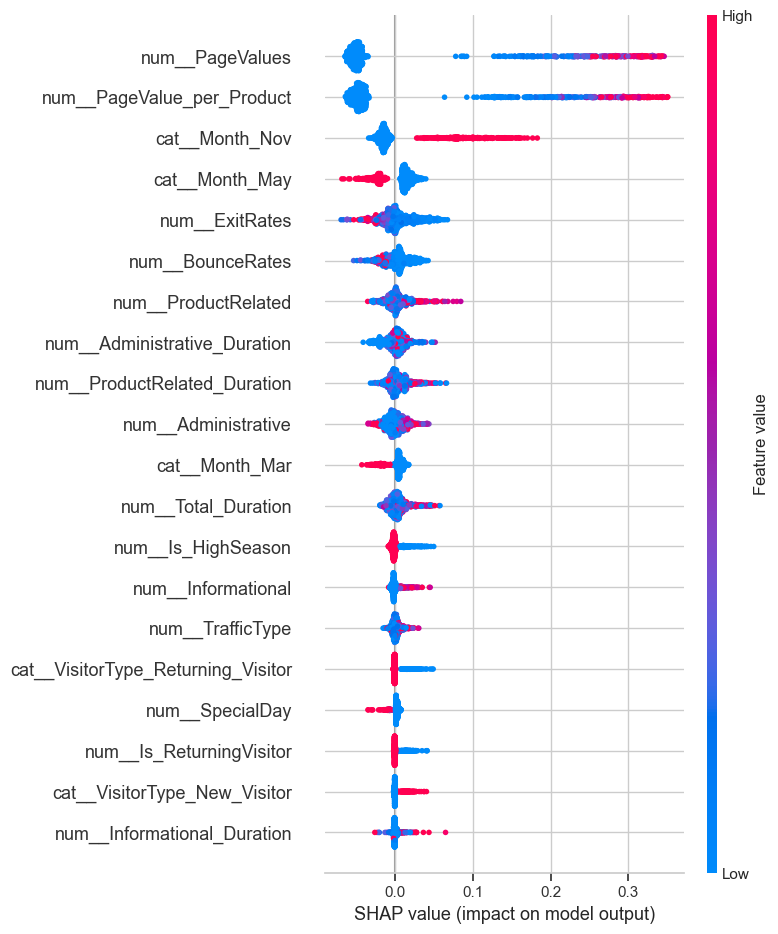

In [11]:
# SHAP summary plot for class 1 (Revenue = 1)

shap.summary_plot(
    shap_values.values[:, :, 1],   # class 1 SHAP matrix
    X_sample_enc,
    feature_names=feature_names,
    plot_type="dot"
)


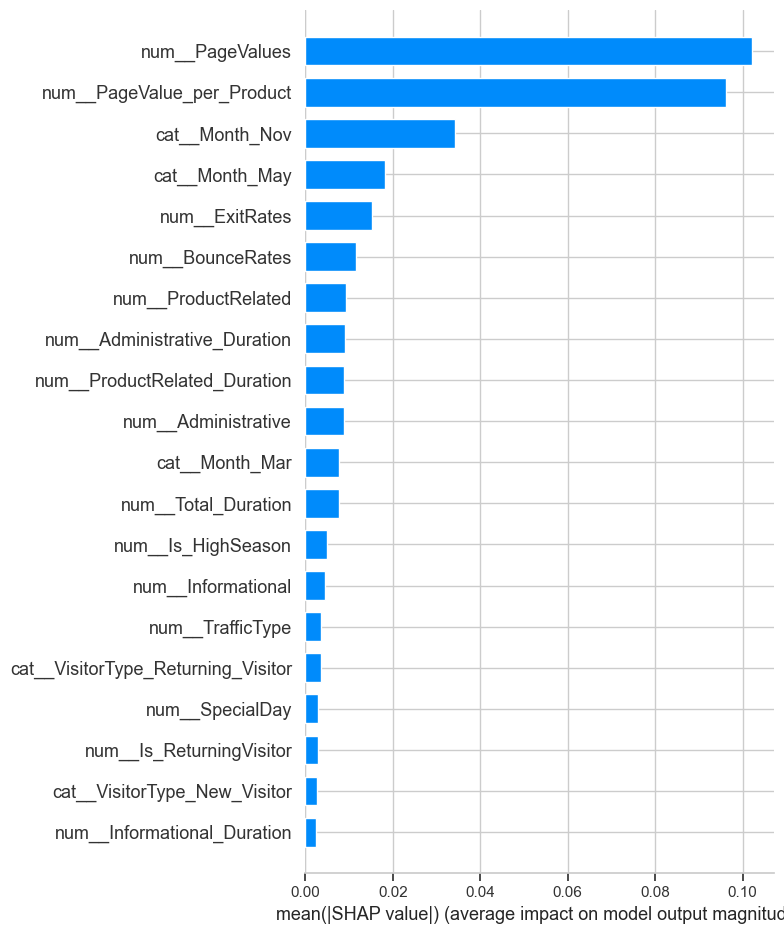

In [12]:
# SHAP bar plot for class 1

shap.summary_plot(
    shap_values.values[:, :, 1],
    X_sample_enc,
    feature_names=feature_names,
    plot_type="bar"
)


# Model Evaluation – Feature Importance & SHAP Analizi

Bu aşamada optimize edilmiş RandomForest modelinin davranışı ve karar mantığı 
feature importance ve SHAP değerleri ile detaylı olarak incelenmiştir.

---

##  Feature Importance (RandomForest)

Modelin global önem katsayılarına göre en önemli özellikler:

1. **PageValues**  
   - Kullanıcının ziyaret ettiği sayfalardan üretilen toplam değer.
   - Yüksek PageValues skorları satın alma ihtimalini ciddi şekilde artırmaktadır.

2. **PageValue_per_Product**  
   - Ürün başına düşen değer; verimlilik göstergesi.
   - Kullanıcının daha hedefli ve satın almaya yakın bir davranış sergilediğini yansıtır.

3. **Month_Nov** / **Month_May**  
   - Kasım ayının (indirim sezonu) satın alma ihtimalini artırdığı görülmektedir.
   - Mayıs ayı da satın alma eğilimini olumlu etkileyen bir dönemdir.

4. **ExitRates ve BounceRates**  
   - Kullanıcı hemen çıkmıyorsa model satın alma olasılığını artırır.
   - Yüksek exit/bounce değerleri satın alma olasılığını düşürür.

5. FE (Feature Engineering) ile üretilen özelliklerin katkısı:
   - **Total_Duration**, **PageValue_per_Product**, **Is_HighSeason**, 
     **Is_ReturningVisitor** gibi feature’lar modele anlamlı katkılar sağlamıştır.

---

##  SHAP Analizi – Revenue=1 Sınıfı İçin Etki

SHAP summary plot, her bir özelliğin model tahminine etkisini göstermektedir:

- **Yüksek PageValues (kırmızı noktalar)** model tahminini güçlü şekilde **pozitif** (Revenue=1) yöne taşımaktadır.
- **ExitRates yüksek olduğunda** (kırmızı noktalar, negatif SHAP) satın alma ihtimali düşmektedir.
- **Month_Nov = True** olduğunda model pozitif tahmine yönelmektedir.
- **Returning_Visitor** feature’ı da pozitif etkiye sahiptir, fakat PageValues kadar güçlü değildir.

Bu analiz, modelin satın alma davranışını nasıl öğrendiğini ve hangi özelliklerin iş açısından kritik olduğunu açıkça ortaya koymaktadır.

---

##  Sonuç

- Model, özellikle PageValues ve ExitRates gibi kullanıcı davranışıyla doğrudan ilişkili değişkenlere dayanmaktadır.
- Feature Engineering ile eklenen değişkenler modele anlamlı katkı sağlamıştır.
- Optimize edilmiş RandomForest, hem yüksek ROC-AUC değeri hem de yorumlanabilir SHAP çıktıları ile final model için en uygun seçenektir.
